In [1]:
import mujoco
# from mujoco import viewer
import numpy as np
import os
import mediapy as media
from mujoco.glfw import glfw
import matplotlib.pyplot as plt

""

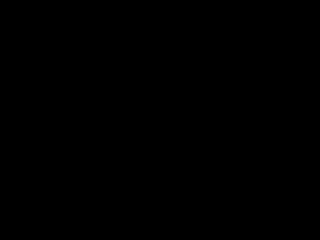

MuJoCo model loaded successfully


In [2]:
# Path to the XML file
xml_path = "x2.xml"

# # Get the full path
# dirname = os.path.dirname(__file__)
# abspath = os.path.join(dirname, xml_path)
# xml_path = abspath

# Initialize MuJoCo model and data
try:
    model = mujoco.MjModel.from_xml_path(xml_path)  # MuJoCo model
    data = mujoco.MjData(model)
    # viewer.launch(model, data)
    renderer = mujoco.Renderer(model)


    # enable joint visualization option:
    scene_option = mujoco.MjvOption()
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

    media.show_image(renderer.render())
    # create the viewer object
    # viewer = mujoco_viewer.MujocoViewer(model, data)

    print("MuJoCo model loaded successfully")
except Exception as e:
    print(f"Error loading MuJoCo model: {e}")
    raise

# Set gravity to a realistic value
model.opt.gravity = (0, 0, -9.81)



""

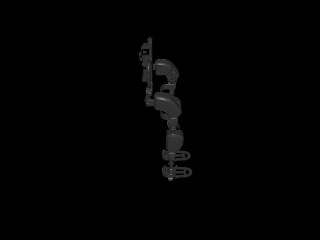

In [3]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [4]:
duration = 5  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)
# print(data.time) # 0.0
while data.time < duration:
  mujoco.mj_step(model, data)
  # print(data.time)
  if len(frames) < data.time * framerate:
    if data.ctrl.size > 0:
      data.ctrl[0] = 10 * np.sin(2 * np.pi * data.time)  # Adjust the force torque to make [hip joint] it swing 
      data.ctrl[1] = 10 * np.cos(2 * np.pi * data.time)  # Apply control to [knee joint], swing by opposite direction
    mujoco.mj_step(model, data)
    renderer.update_scene(data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

In [5]:
print('Total number of DoFs in the model:', model.nv)
print('Generalized positions:', data.qpos)
print('Generalized velocities:', data.qvel)

Total number of DoFs in the model: 9
Generalized positions: [-0.34788949  0.14354904 -0.20434045 -0.11416597  0.31850642  0.44808791
  0.10019842 -0.01609461 -0.08410382]
Generalized velocities: [-0.26403872 -1.19843879 -1.46247751  3.16895753 -1.70648002  1.06884205
  0.80480333  0.03245312 -0.83725645]


In [6]:
# Input parameters. The desired starting point and ending point(in angle)
q0_init = 0   # Initial joint angle of hip joint
q0_end = np.pi/10    #desired end joint angle of hip joint
q1_init = 0 #initial joint angle of knee joint
q1_end = -np.pi/10 #desired end joint angle of knee joint

# Time duration for the motion
t_init = 0 
t_end = 10

t = []
qact0 = []
qref0 = []
qact1 = []
qref1 = []

# Generate the trajectory
# Input: initial time, final time, initial joint angle, final joint angle
# Output: cubirc trajectory [a0 a1 a2 a3]
def generate_trajectory(t0, tf, q0, qf):
    time_diff3 = (tf - t0)**3
    #define a0
    a0 = qf*(t0**2)*(3*tf-t0)+q0*(tf**2)*(tf-3*t0)
    a0 = a0 / time_diff3

    #define a1
    a1 = 6 * t0 * tf * (q0 - qf)
    a1 = a1 / time_diff3

    #define a2
    a2 = 3 * (tf + t0)*(qf - q0)
    a2 = a2 / time_diff3

    #define a3
    a3 = 2 * (q0 - qf)
    a3 = a3 / time_diff3

    return a0, a1, a2, a3

def init_controller(model, data):
    global a_jnt0, a_jnt1

    a_jnt0 = generate_trajectory(t_init, t_end, q0_init, q0_end)
    a_jnt1 = generate_trajectory(t_init, t_end, q1_init, q1_end)

def controller(model, data):
    global a_jnt0, a_jnt1

    time = data.time
    if (time > t_end):
        time = t_end
    if (time < t_init):
        time = t_init
    #calculate the reference(theoratical) angle at time t
    q0_ref = a_jnt0[0] + a_jnt0[1]*time + a_jnt0[2]*(time**2) + a_jnt0[3]*(time**3)
    q0dot_ref = a_jnt0[1] + 2*a_jnt0[2]*time + 3*a_jnt0[3]*(time**2)
    q1_ref = a_jnt1[0] + a_jnt1[1]*time + a_jnt1[2]*(time**2) + a_jnt1[3]*time**3
    q1dot_ref = a_jnt1[1] + 2*a_jnt1[2]*time + 3*a_jnt1[3]*(time**2)

    #jump into the control!
    #Method1: PD Control

    kp = 500    #User defined, needed to be tuned
    kd = 50 #User defined, needed to be tuned

    #calculated torque based on PD control with angle difference error (q_actual - q_ref) and velocity difference error (qdot_actual - qdot_ref
    data.ctrl[0] = -kp*(data.qpos[0] - q0_ref) - kd*(data.qvel[0] - q0dot_ref)
    data.ctrl[1] = -kp*(data.qpos[1] - q1_ref) - kd*(data.qvel[1] - q1dot_ref)
    t.append(data.time)
    qact0.append(data.qpos[0])
    qref0.append(q0_ref)
    qact1.append(data.qpos[1])
    qref1.append(q1_ref)
    
    #Feedback linearization, model based control
    # M = np.zeros((2,2))






In [7]:
def keyboard(window, key, scancode, act, mods):
    if act == glfw.PRESS and key == glfw.KEY_BACKSPACE:
        mujoco.mj_resetData(model, data)
        mujoco.mj_forward(model, data)

def mouse_button(window, button, act, mods):
    # update button state
    global button_left
    global button_middle
    global button_right

    button_left = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_LEFT) == glfw.PRESS)
    button_middle = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_MIDDLE) == glfw.PRESS)
    button_right = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_RIGHT) == glfw.PRESS)

    # update mouse position
    glfw.get_cursor_pos(window)

def mouse_move(window, xpos, ypos):
    # compute mouse displacement, save
    global lastx
    global lasty
    global button_left
    global button_middle
    global button_right

    dx = xpos - lastx
    dy = ypos - lasty
    lastx = xpos
    lasty = ypos

    # no buttons down: nothing to do
    if (not button_left) and (not button_middle) and (not button_right):
        return

    # get current window size
    width, height = glfw.get_window_size(window)

    # get shift key state
    PRESS_LEFT_SHIFT = glfw.get_key(
        window, glfw.KEY_LEFT_SHIFT) == glfw.PRESS
    PRESS_RIGHT_SHIFT = glfw.get_key(
        window, glfw.KEY_RIGHT_SHIFT) == glfw.PRESS
    mod_shift = (PRESS_LEFT_SHIFT or PRESS_RIGHT_SHIFT)

    # determine action based on mouse button
    if button_right:
        if mod_shift:
            action = mujoco.mjtMouse.mjMOUSE_MOVE_H
        else:
            action = mujoco.mjtMouse.mjMOUSE_MOVE_V
    elif button_left:
        if mod_shift:
            action = mujoco.mjtMouse.mjMOUSE_ROTATE_H
        else:
            action = mujoco.mjtMouse.mjMOUSE_ROTATE_V
    else:
        action = mujoco.mjtMouse.mjMOUSE_ZOOM
    mujoco.mjv_moveCamera(model, action, dx/height,
                      dy/height, scene, cam)

def scroll(window, xoffset, yoffset):
    action = mujoco.mjtMouse.mjMOUSE_ZOOM
    mujoco.mjv_moveCamera(model, action, 0.0, -0.05 *
                      yoffset, scene, cam)
cam = mujoco.MjvCamera()                        # Abstract camera
opt = mujoco.MjvOption() 
# Init GLFW, create window, make OpenGL context current, request v-sync
glfw.init()
window = glfw.create_window(1200, 900, "Demo", None, None)
glfw.make_context_current(window)
glfw.swap_interval(1)

# initialize visualization data structures
mujoco.mjv_defaultCamera(cam)
mujoco.mjv_defaultOption(opt)
scene = mujoco.MjvScene(model, maxgeom=10000)
context = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_150.value)

# install GLFW mouse and keyboard callbacks
glfw.set_key_callback(window, keyboard)
glfw.set_cursor_pos_callback(window, mouse_move)
glfw.set_mouse_button_callback(window, mouse_button)
glfw.set_scroll_callback(window, scroll)

# Example on how to set camera configuration
cam.azimuth = 90 ; cam.elevation = 5 ; cam.distance =  6
cam.lookat =np.array([ 0.0 , 0.0 , 0.0 ])

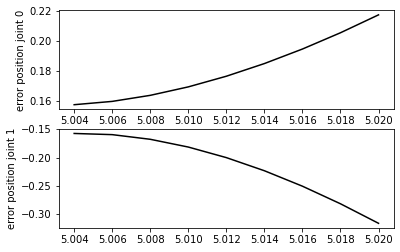

In [8]:
# Generate the video based on PD control!!

print_camera_config = 0
simend = 3 #simulation time

# Initialize the controller
data.qpos[0] = q0_init
data.qpos[1] = q1_init

init_controller(model, data)
mujoco.set_mjcb_control(controller)

# Simulation parameters
duration = 5  # (seconds)
framerate = 60  # (Hz)

while not glfw.window_should_close(window):
    time_prev = data.time

    while (data.time - time_prev < 1.0/60.0):
        mujoco.mj_step(model, data)

    if (data.time>=simend):
        plt.figure(1)
        plt.subplot(2, 1, 1)
        # plt.plot(t,qact0,'r-')
        # plt.plot(t,qref0,'k');
        plt.plot(t,np.subtract(qref0,qact0),'k')
        plt.ylabel('error position joint 0');
        plt.subplot(2, 1, 2)
        # plt.plot(t,qact1,'r-')
        # plt.plot(t,qref1,'k');
        plt.plot(t,np.subtract(qref1,qact1),'k')
        plt.ylabel('error position joint 1');
        plt.show(block=False)
        plt.pause(10)
        plt.close()
        break;

    # get framebuffer viewport
    viewport_width, viewport_height = glfw.get_framebuffer_size(
        window)
    viewport = mujoco.MjrRect(0, 0, viewport_width, viewport_height)

    #print camera configuration (help to initialize the view)
    if (print_camera_config==1):
        print('cam.azimuth =',cam.azimuth,';','cam.elevation =',cam.elevation,';','cam.distance = ',cam.distance)
        print('cam.lookat =np.array([',cam.lookat[0],',',cam.lookat[1],',',cam.lookat[2],'])')

    # Update scene and render
    mujoco.mjv_updateScene(model, data, opt, None, cam,
                       mujoco.mjtCatBit.mjCAT_ALL.value, scene)
    mujoco.mjr_render(viewport, scene, context)

    # swap OpenGL buffers (blocking call due to v-sync)
    glfw.swap_buffers(window)

    # process pending GUI events, call GLFW callbacks
    glfw.poll_events()

glfw.terminate()